In [14]:
#| code-summary: Load Packages
#| code-fold: true

# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm


In [15]:
#| echo: false
from IPython.display import display
pd.options.display.notebook_repr_html = False

In [16]:
#| code-summary: Options
#| code-fold: true

# pandas options
pd.set_option("mode.copy_on_write", True)
pd.options.display.precision = 2
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7

# Numpy options
np.set_printoptions(precision = 2, suppress=True)

In [17]:
flights = pd.read_csv('../data/flights.csv')
airlines = pd.read_csv('../data/airlines.csv')
airports = pd.read_csv('../data/airports.csv')
planes = pd.read_csv('../data/planes.csv')
weather = pd.read_csv('../data/weather.csv')

### 1.

In [18]:
# 1. Add the location of the origin and destination (i.e. the lat and lon in airports) to flights.

In [19]:
airport_location = airports[['faa', 'lat', 'lon']]
airport_location

      faa   lat    lon
0     04G 41.13 -80.62
1     06A 32.46 -85.68
2     06C 41.99 -88.10
...   ...   ...    ...
1455  ZWI 39.74 -75.55
1456  ZWU 38.90 -77.01
1457  ZYP 40.75 -73.99

[1458 rows x 3 columns]

In [20]:
flights = flights.merge(airport_location, left_on='origin', right_on='faa').drop('faa', axis=1)

In [21]:
# dest의 경우 airports에 없는 값이 존재
flights[~flights.dest.isin(airport_location.faa)]

        year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
21      2013      1    1    701.00             700       1.00   1123.00   
57      2013      1    1    913.00             918      -5.00   1346.00   
60      2013      1    1    926.00             929      -3.00   1404.00   
...      ...    ...  ...       ...             ...        ...       ...   
336754  2013      9   30   2050.00            2045       5.00     20.00   
336765  2013      9   30   2145.00            2145       0.00    115.00   
336774  2013      9   30   2349.00            2359     -10.00    325.00   

        sched_arr_time  arr_delay carrier  flight tailnum origin dest  \
21                1154     -31.00      UA    1203  N77296    EWR  SJU   
57                1416     -30.00      UA    1519  N24715    EWR  STT   
60                1421     -17.00      B6     215  N775JB    EWR  SJU   
...                ...        ...     ...     ...     ...    ...  ...   
336754              53     -33.00 

In [22]:
# how="left" 필요, suffixes 옵션 사용하면 편리
flights = flights.merge(airport_location, left_on='dest', right_on='faa', how='left', suffixes=("_origin", "_dest")).drop('faa', axis=1)

In [23]:
flights

        year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0       2013      1    1    517.00             515       2.00    830.00   
1       2013      1    1    554.00             558      -4.00    740.00   
2       2013      1    1    555.00             600      -5.00    913.00   
...      ...    ...  ...       ...             ...        ...       ...   
336773  2013      9   30   2307.00            2255      12.00   2359.00   
336774  2013      9   30   2349.00            2359     -10.00    325.00   
336775  2013      9   30       NaN            1455        NaN       NaN   

        sched_arr_time  arr_delay carrier  ...  origin dest air_time distance  \
0                  819      11.00      UA  ...     EWR  IAH   227.00     1400   
1                  728      12.00      UA  ...     EWR  ORD   150.00      719   
2                  854      19.00      B6  ...     EWR  FLL   158.00     1065   
...                ...        ...     ...  ...     ...  ...      ...      .

### 2.

In [31]:
# 2. Is there a relationship between the age of a plane and its delays?

plane_age = (
    planes[['tailnum', 'year']]
    .merge(flights, on='tailnum', how="right", suffixes=("_plane", ""))
    .drop('tailnum', axis=1)
    .assign(age=lambda x: x.year - x.year_plane)
)

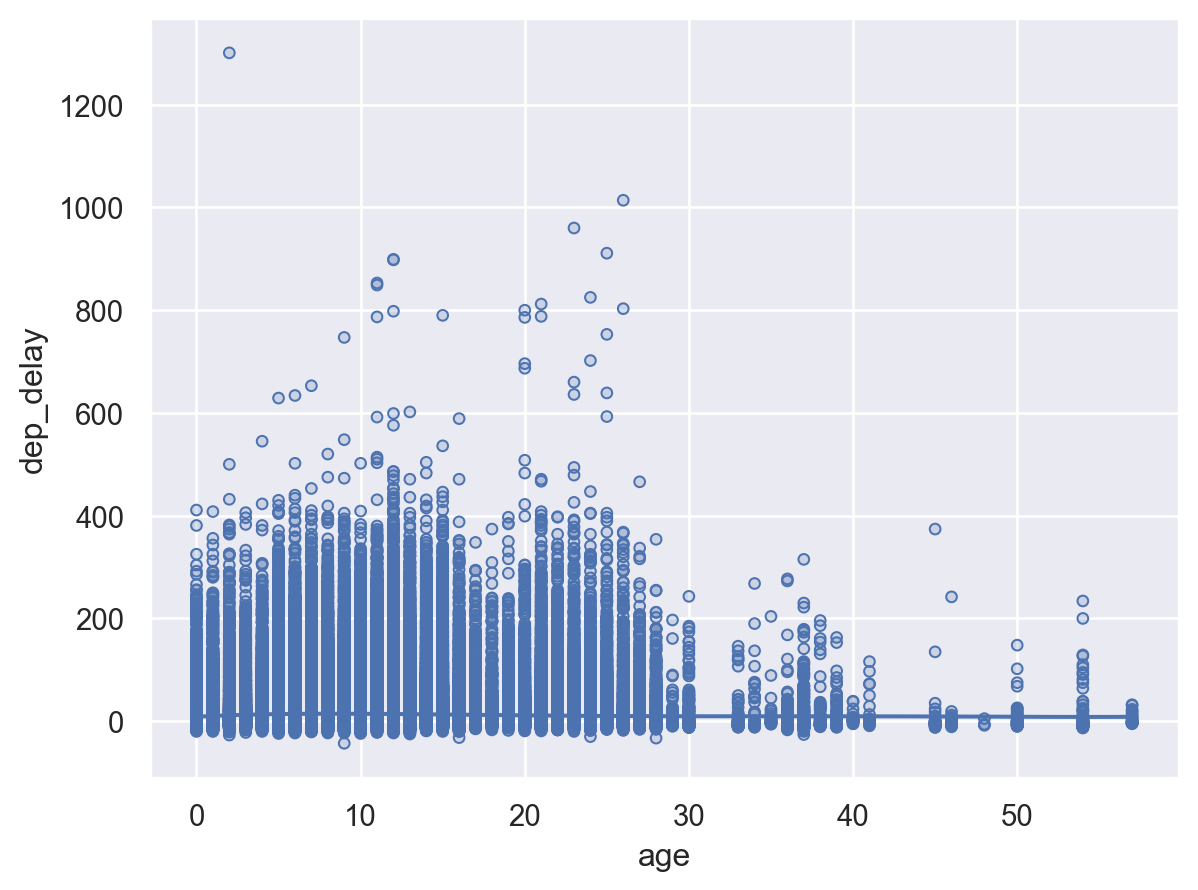

In [41]:
(
    so.Plot(plane_age, x='age', y='dep_delay')
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(5))
)

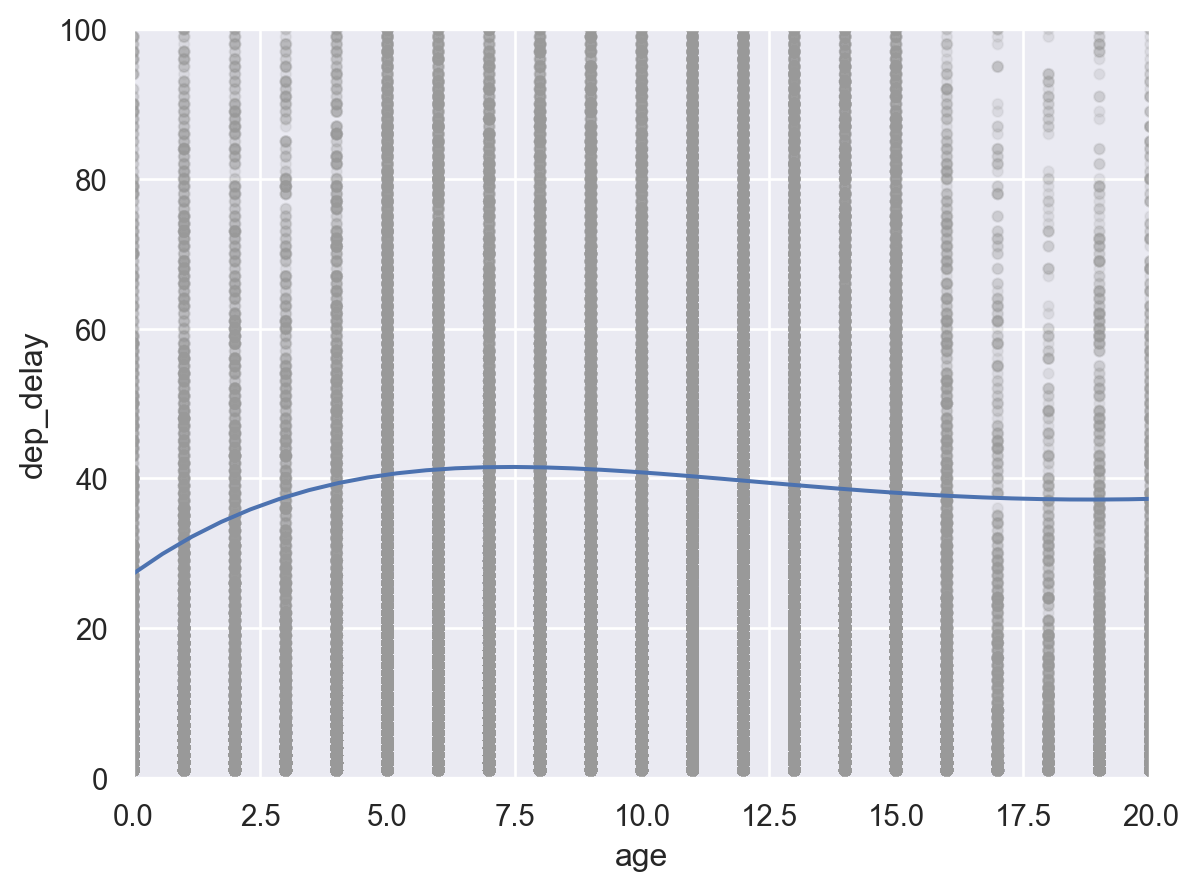

In [42]:
(
    so.Plot(plane_age.query('dep_delay > 0'), x='age', y='dep_delay')
    .add(so.Dots(alpha=.1, color=".6"))
    .add(so.Line(), so.PolyFit(5))
    .limit(y=(0, 100), x=(0, 20))
)

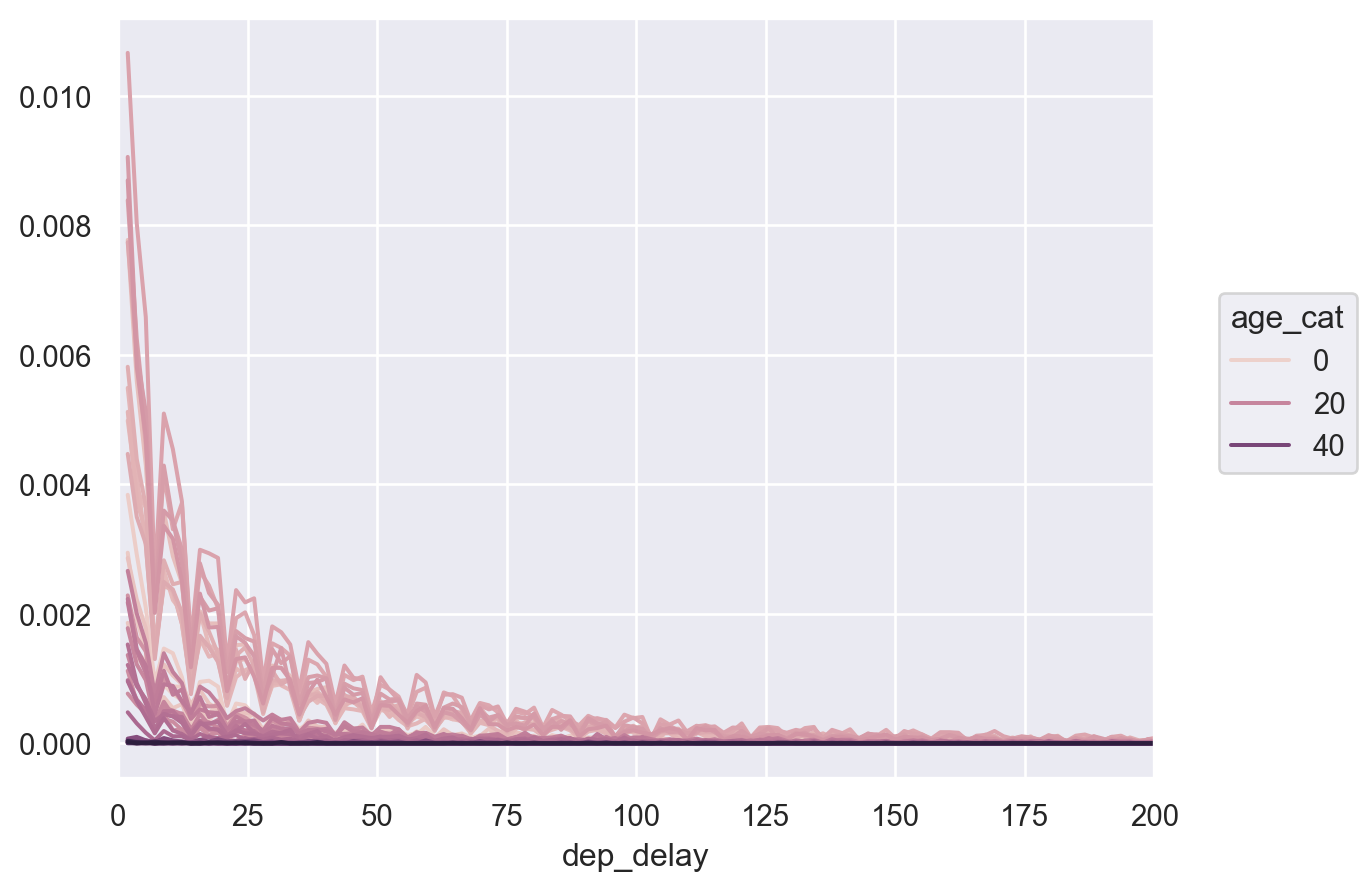

In [63]:
(
    so.Plot(plane_age.query('dep_delay > 0'), x='dep_delay', color="age_cat")
    .add(so.Line(), so.Hist(stat="proportion"))
    .limit(x=(0, 200))
)

In [65]:
age_delay = (
    plane_age.query('dep_delay > 0 & dep_delay < 100')
    .groupby("age")["dep_delay"]
    .agg(["mean", "median", "count"])
    .reset_index()
)
age_delay

     age  mean  median  count
0   0.00 22.73   13.00   1686
1   1.00 19.97   11.00   2761
2   2.00 22.54   13.00   2092
..   ...   ...     ...    ...
43 50.00 19.88   14.50     16
44 54.00 26.62   15.00     26
45 57.00 14.91   13.00     11

[46 rows x 4 columns]

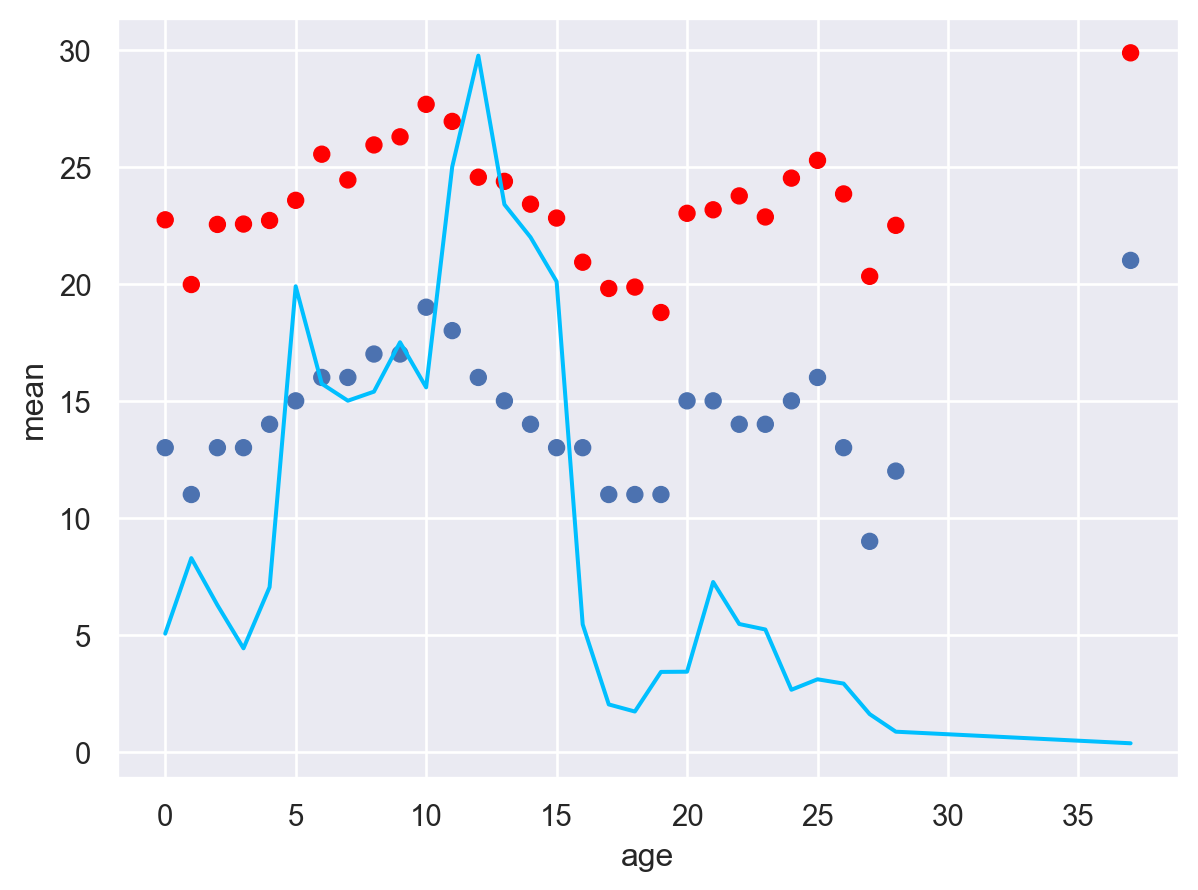

In [71]:
(
    so.Plot(age_delay.query('count > 100'), x='age')
    .add(so.Dot(color="red"), y="mean")
    .add(so.Dot(), y="median")
    .add(so.Line(color="deepskyblue"), y=age_delay["count"]/1000*3)
)

### 3.

In [ ]:
# 3. What weather conditions make it more likely to see a delay?

In [ ]:
flights_weather = flights.merge(weather)

In [75]:
# 강수량 precipitation
precip = flights_weather.groupby("precip")["dep_delay"].agg(["mean", "median"]).reset_index()
precip

    precip   mean  median
0     0.00  11.37   -2.00
1     0.01  29.80    3.00
2     0.02  24.08    2.00
..     ...    ...     ...
52    0.82  94.67   36.00
53    0.94  27.85   19.00
54    1.21 113.11   65.50

[55 rows x 3 columns]

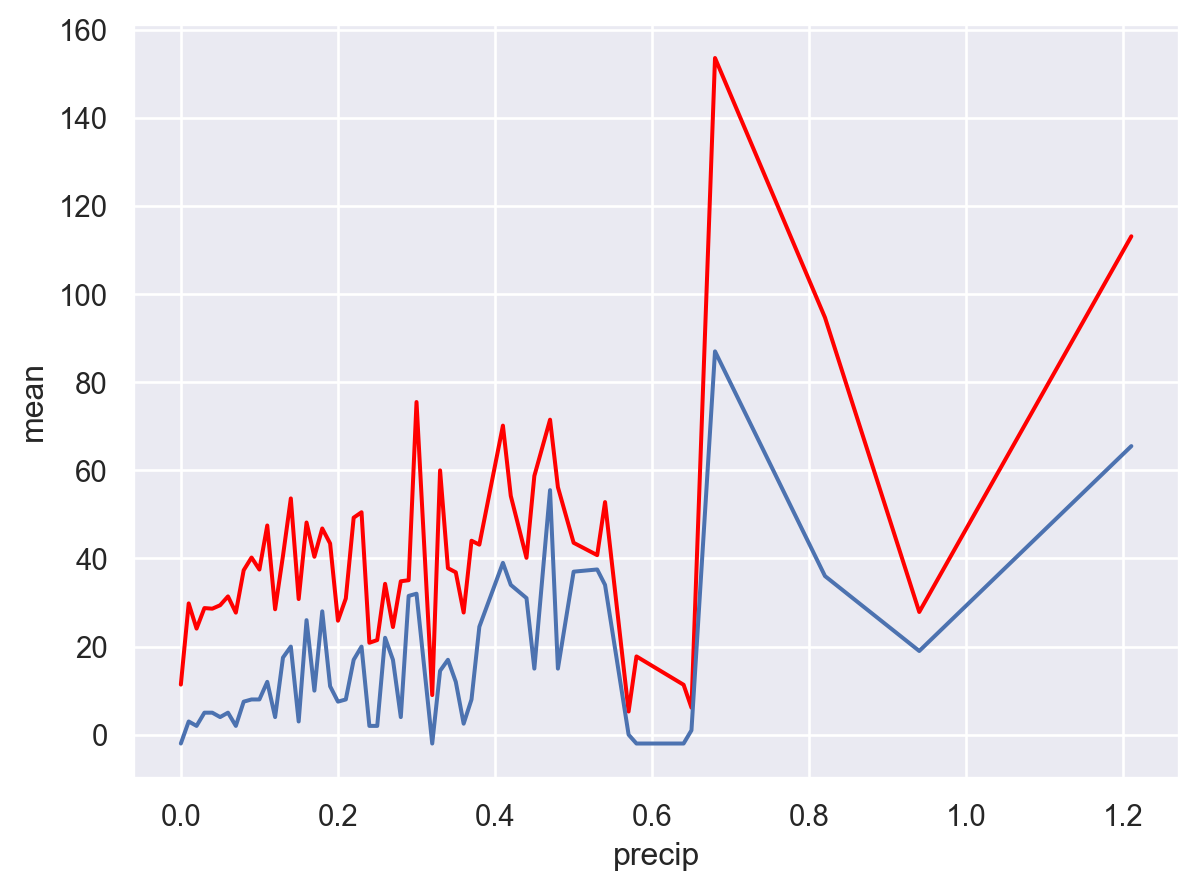

In [76]:
(
    so.Plot(precip, x='precip')
    .add(so.Line(color="red"), y="mean")
    .add(so.Line(), y="median")
)

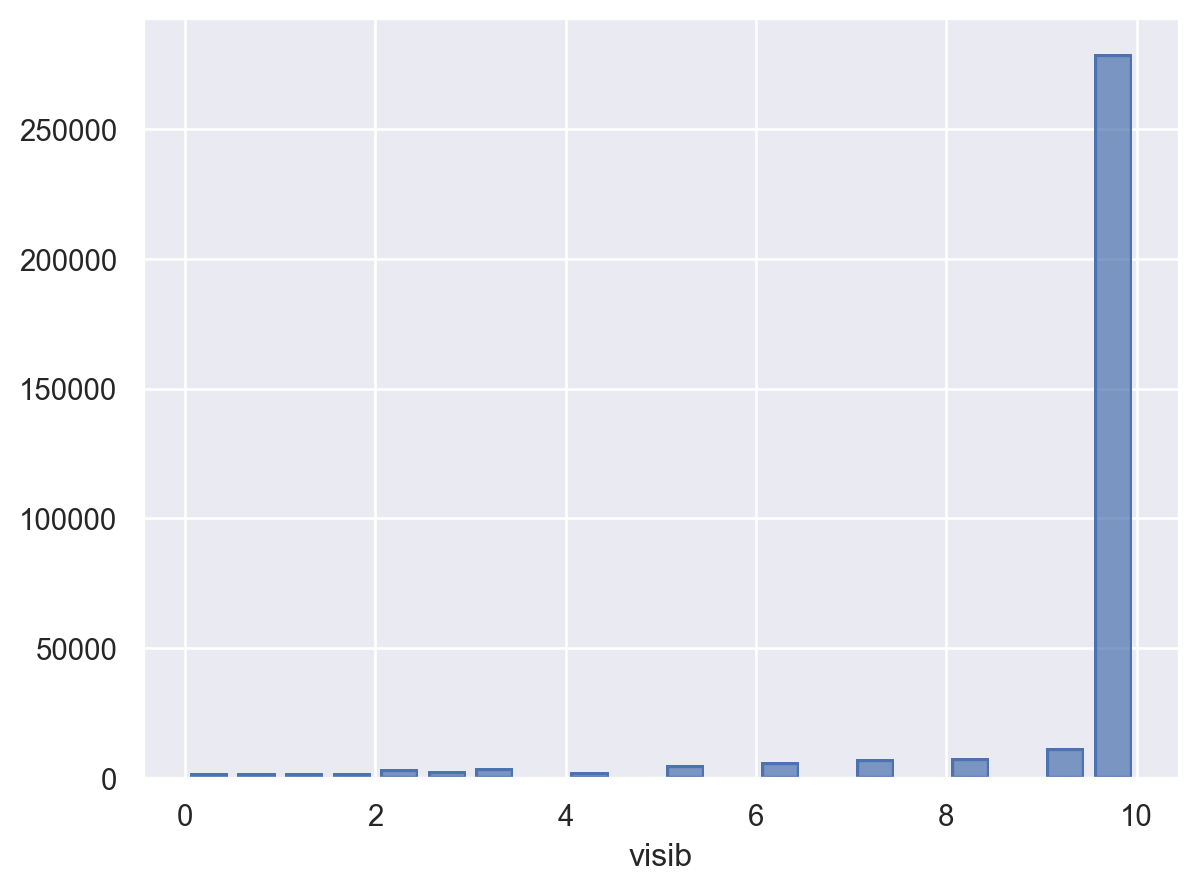

In [78]:
# 시야 visibility
(
    so.Plot(flights_weather, x='visib')
    .add(so.Bar(), so.Hist())
)

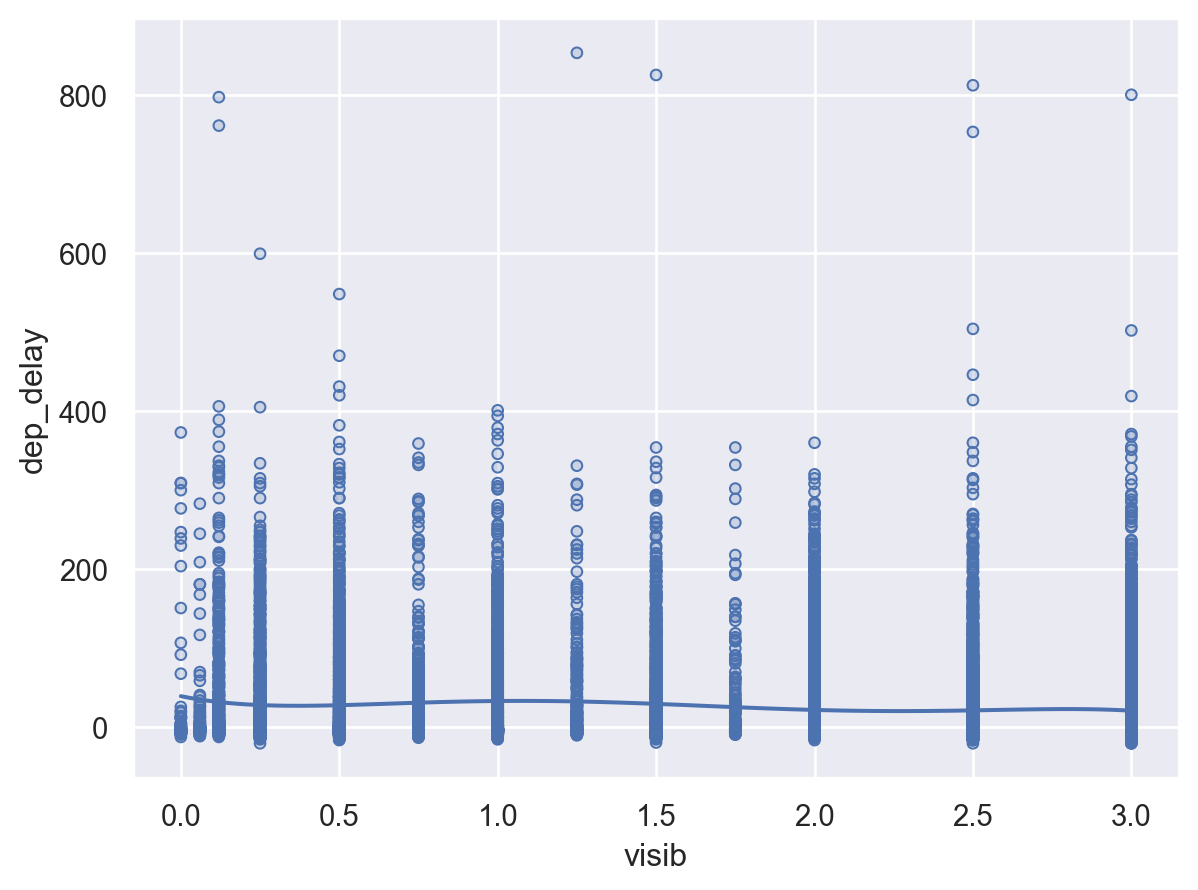

In [82]:
(
    so.Plot(flights_weather.query('visib < 4'), x='visib', y='dep_delay')
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(5))
    #.limit(y=(0, 100))
)

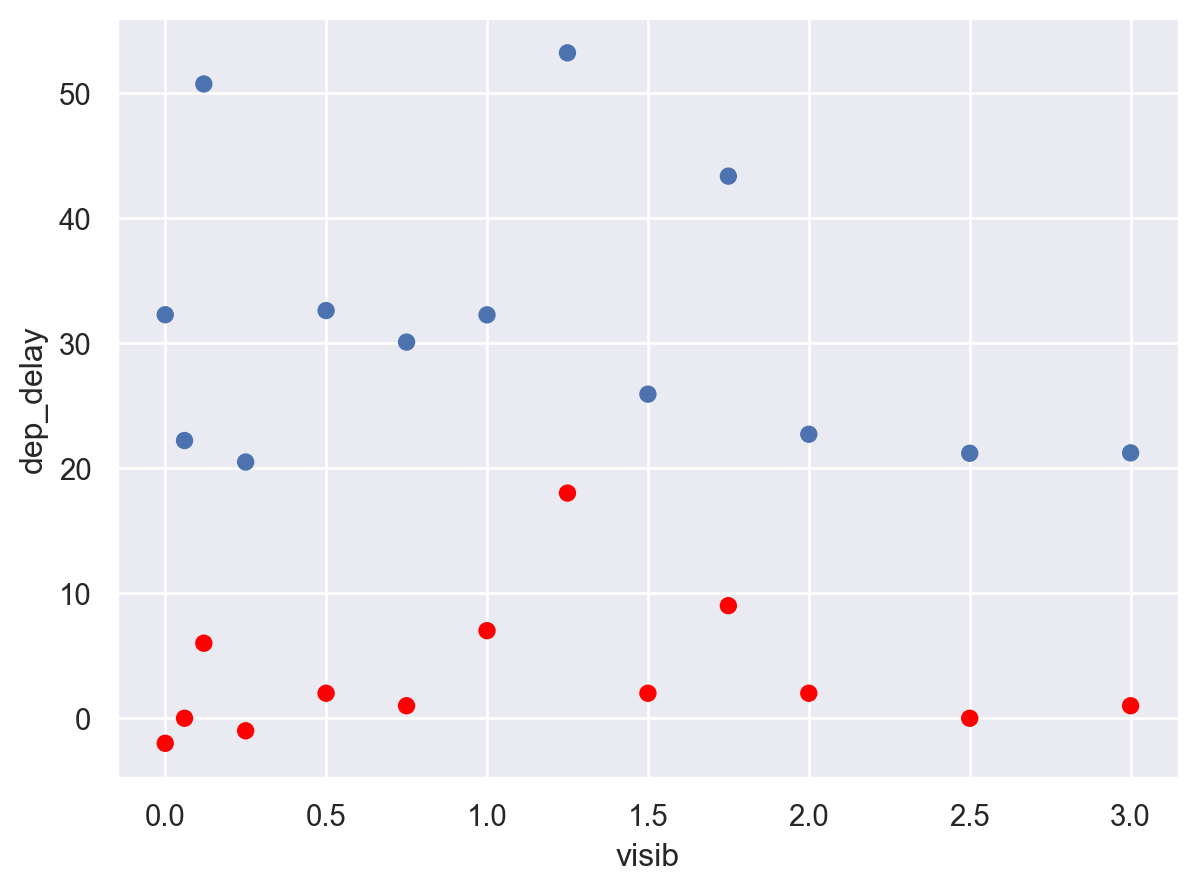

In [85]:
(
    so.Plot(flights_weather.query('visib < 4'), x='visib', y='dep_delay')
    .add(so.Dot(), so.Agg())
    .add(so.Dot(color="red"), so.Agg("median"))
    #.limit(y=(0, 100))
)

### 4.

In [ ]:
# 4. flights 테이블에서 하루 평균 도착지연(arr_delay)가 가장 큰 10일에 해당하는 항공편을 선택

In [87]:
delay_top = flights.groupby(["year", "month", "day"])["arr_delay"].mean().sort_values(ascending=False).head(10)
delay_top

year  month  day
2013  3      8     85.86
      6      13    63.75
      7      22    62.76
                    ... 
      12     17    55.87
      8      8     55.48
      12     5     51.67
Name: arr_delay, Length: 10, dtype: float64

In [90]:
flights.merge(delay_top.reset_index(name="daily_delay"), on=["year", "month", "day"])

      year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0     2013     12    5     32.00            1930     302.00    228.00   
1     2013     12    5     50.00            2046     244.00    233.00   
2     2013     12    5    457.00             500      -3.00    637.00   
...    ...    ...  ...       ...             ...        ...       ...   
9834  2013      9   12       NaN            1510        NaN       NaN   
9835  2013      9   12       NaN            2015        NaN       NaN   
9836  2013      9   12       NaN            1829        NaN       NaN   

      sched_arr_time  arr_delay carrier  ...  dest air_time distance hour  \
0               2136     292.00      EV  ...   CHS    94.00      628   19   
1               2224     249.00      EV  ...   GSO    80.00      445   20   
2                651     -14.00      US  ...   CLT    81.00      529    5   
...              ...        ...     ...  ...   ...      ...      ...  ...   
9834            1630        Na

### 5.

In [91]:
#5. flights 테이블의 도착지(dest)에 대한 공항정보가 airports 테이블에 없는 그러한 도착지(dest)를 구하면?

flights[~flights.dest.isin(airports.faa)]

        year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
21      2013      1    1    701.00             700       1.00   1123.00   
57      2013      1    1    913.00             918      -5.00   1346.00   
60      2013      1    1    926.00             929      -3.00   1404.00   
...      ...    ...  ...       ...             ...        ...       ...   
336754  2013      9   30   2050.00            2045       5.00     20.00   
336765  2013      9   30   2145.00            2145       0.00    115.00   
336774  2013      9   30   2349.00            2359     -10.00    325.00   

        sched_arr_time  arr_delay carrier  ...  origin dest air_time distance  \
21                1154     -31.00      UA  ...     EWR  SJU   188.00     1608   
57                1416     -30.00      UA  ...     EWR  STT   189.00     1634   
60                1421     -17.00      B6  ...     EWR  SJU   191.00     1608   
...                ...        ...     ...  ...     ...  ...      ...      .

### 6.

In [94]:
# 6. Filter flights (항공편) in flights to only show flights with planes that have flown at least 100 flights.

n_planes = (
    flights.groupby("tailnum")["flight"].count()
    .reset_index(name="n")
    .query('n >= 100')
)
n_planes

     tailnum    n
1     N0EGMQ  371
2     N10156  153
6     N10575  289
...      ...  ...
4003  N979DL  126
4036  N996DL  102
4042  N9EAMQ  248

[1217 rows x 2 columns]

In [95]:
flights.merge(n_planes)

        year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0       2013      1    1    517.00             515       2.00    830.00   
1       2013      1    8   1435.00            1440      -5.00   1717.00   
2       2013      1    9    717.00             700      17.00    812.00   
...      ...    ...  ...       ...             ...        ...       ...   
228387  2013      9   26   1758.00            1759      -1.00   2101.00   
228388  2013      9   29   1112.00            1115      -3.00   1342.00   
228389  2013      9   30    654.00             700      -6.00    956.00   

        sched_arr_time  arr_delay carrier  ...  dest air_time distance hour  \
0                  819      11.00      UA  ...   IAH   227.00     1400    5   
1                 1746     -29.00      UA  ...   MIA   150.00     1085   14   
2                  815      -3.00      UA  ...   BOS    39.00      200    7   
...                ...        ...     ...  ...   ...      ...      ...  ...   
2283

### 7.

In [ ]:
# 7. Find the 48 hours (over the course of the whole year) that have the worst (departure) delays.

In [96]:
(
    flights.groupby(["year", "month", "day", "hour"])["dep_delay"]
    .mean()
    .nlargest(48)
)

year  month  day  hour
2013  2      9    10     269.00
      4      10   22     176.40
                  20     170.16
                          ...  
             19   21     117.12
      6      24   17     116.11
      3      8    11     115.62
Name: dep_delay, Length: 48, dtype: float64

### 8.

In [ ]:
# 8. You might expect that there’s an implicit relationship between plane and airline, because each plane is flown by a single airline. Confirm or reject this hypothesis using the tools you’ve learned above.

In [100]:
# 즉, 각 비행기는 특정 항공사에서만 운행되는가의 질문임. 2개 이상의 항공사에서 운항되는 비행기가 있는지 확인해 볼 것

planes_carriers = flights.value_counts(["tailnum", "carrier"]).reset_index().drop(columns="count")
planes_carriers

     tailnum carrier
0     N725MQ      MQ
1     N722MQ      MQ
2     N723MQ      MQ
...      ...     ...
4057  N670US      DL
4058  N955DN      DL
4059  N8618N      WN

[4060 rows x 2 columns]

In [108]:
planes_share = (
    planes_carriers.groupby("tailnum")["carrier"].count()
    .reset_index(name="n")
    .query('n > 1')
)
planes_share

     tailnum  n
195   N146PQ  2
224   N153PQ  2
342   N176PQ  2
...      ... ..
4021  N989AT  2
4023  N990AT  2
4031  N994AT  2

[17 rows x 2 columns]

In [110]:
# 그리고, 2개 이상의 항공사에서 운항되는 비행기들만 포함하고, 그 항공사들의 full name을 함께 포함하는 테이블을 만들어 볼 것

flights.merge(planes_share).merge(airlines)

     year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0    2013      1   11   1244.00            1250      -6.00   1459.00   
1    2013      1   11   1821.00            1830      -9.00   2014.00   
2    2013      1   15    612.00             615      -3.00    927.00   
..    ...    ...  ...       ...             ...        ...       ...   
821  2013      7    9   2224.00            1859     205.00     16.00   
822  2013      7   14   1310.00            1310       0.00   1532.00   
823  2013      8   27   1324.00            1310      14.00   1525.00   

     sched_arr_time  arr_delay carrier  ...  air_time distance hour minute  \
0              1449      10.00      9E  ...     92.00      488   12     50   
1              2044     -30.00      9E  ...     79.00      488   18     30   
2               855      32.00      9E  ...    134.00      760    6     15   
..              ...        ...     ...  ...       ...      ...  ...    ...   
821            2121     175.00   